In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

Setup complete!


In [2]:
# Initialize DuckDB connection
conn = duckdb.connect()

# Configure DuckDB for S3 access
conn.execute("SET threads=100")
conn.execute("INSTALL httpfs")
conn.execute("LOAD httpfs")
conn.execute("""
    CREATE OR REPLACE SECRET s3 (
        TYPE S3,
        ENDPOINT 'minio.carlboettiger.info',
        URL_STYLE 'path',
        USE_SSL 'true',
        KEY_ID '',
        SECRET ''
    )
""")

# Test connection
result = conn.execute("SELECT 'Connection successful!' as status").fetchdf()
print("✅ DuckDB configured for S3 access")
print(result)

✅ DuckDB configured for S3 access
                   status
0  Connection successful!


In [3]:
def analyze_hydrobasins_for_country(country_code: str, country_name: str, top_n: int = 3) -> pd.DataFrame:
    """
    Analyze Level 6 HydroBASINS for a given country.
    
    Args:
        country_code: ISO 2-letter country code (e.g., 'US', 'CN')
        country_name: Full country name for display
        top_n: Number of top basins to return
        
    Returns:
        DataFrame with top hydrobasins and their scores
    """
    
    query = f"""
    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = '{country_code}' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetlands
            ROUND(COALESCE(SUM(carb.carbon), 0), 2) as total_carbon,
            -- C. Protected wetland fraction
            ROUND(
                COUNT(DISTINCT CASE WHEN wdpa.h8 IS NOT NULL THEN bw.h8 END)::FLOAT / 
                NULLIF(COUNT(DISTINCT bw.h8), 0),
                3
            ) as protected_fraction,
            -- D. Average NCP score
            ROUND(AVG(ncp.ncp), 3) as avg_ncp_score
        FROM basin_wetlands bw
        LEFT JOIN read_parquet('s3://public-carbon/hex/vulnerable-carbon/**') carb 
            ON bw.h8 = carb.h8 AND bw.h0 = carb.h0
        LEFT JOIN read_parquet('s3://public-wdpa/hex/**') wdpa 
            ON bw.h8 = wdpa.h8 AND bw.h0 = wdpa.h0
        LEFT JOIN read_parquet('s3://public-ncp/hex/ncp_biod_nathab/**') ncp 
            ON bw.h8 = ncp.h8 AND bw.h0 = ncp.h0
        GROUP BY bw.basin_id, bw.PFAF_ID, bw.UP_AREA, bw.SUB_AREA
    )
    SELECT 
        basin_id,
        PFAF_ID,
        UP_AREA as upstream_area_km2,
        SUB_AREA as basin_area_km2,
        wetland_hex_count,
        wetland_area_hectares,
        total_carbon,
        protected_fraction,
        avg_ncp_score,
        -- Composite score (normalize each metric to 0-1 scale, then average)
        ROUND(
            (wetland_area_hectares / MAX(wetland_area_hectares) OVER () * 0.25 +
             total_carbon / NULLIF(MAX(total_carbon) OVER (), 0) * 0.25 +
             (1 - protected_fraction) * 0.25 +
             avg_ncp_score * 0.25),
            3
        ) as composite_score
    FROM basin_metrics
    WHERE wetland_hex_count > 0
    ORDER BY composite_score DESC
    LIMIT {top_n};
    """
    
    print(f"\n{'='*80}")
    print(f"Analyzing: {country_name} ({country_code})")
    print(f"{'='*80}")
    
    # Show the SQL query for comparison
    print("\n=== Generated SQL Query ===")
    print(query)
    print()
    
    # Execute query and get results as DataFrame
    df = conn.execute(query).fetchdf()
    
    if len(df) > 0:
        df['country'] = country_name
        df['country_code'] = country_code
        
        print(f"\nTop {top_n} Priority Hydrobasins in {country_name}:")
        print(df[[
            'basin_id', 'PFAF_ID', 'wetland_area_hectares', 'total_carbon', 
            'protected_fraction', 'avg_ncp_score', 'composite_score'
        ]].to_string(index=False))
    else:
        print(f"\nNo wetland data found for {country_name}")
        df['country'] = country_name
        df['country_code'] = country_code
    
    return df

## Priority Watershed Analysis Methodology

This analysis identifies priority watersheds for wetland conservation based on a composite score that integrates multiple conservation criteria. We use HydroBASINS Level 6 watersheds as our spatial units of analysis.

### Data Sources

The analysis integrates the following global datasets:

1. **Wetlands**: Global Lakes and Wetlands Database (GLWD) - provides wetland extent and type
2. **Carbon Storage**: Vulnerable carbon data from Conservation International - represents irrecoverable carbon stocks
3. **Protected Areas**: World Database on Protected Areas (WDPA) - identifies existing conservation coverage
4. **Biodiversity Value**: Nature's Contributions to People (NCP) scores - biodiversity and ecosystem service importance
5. **Watersheds**: HydroBASINS Level 6 - watershed boundaries for analysis units

### Composite Score Calculation

Each watershed receives a **composite score** (0-1 scale) based on four equally-weighted criteria:

#### 1. Wetland Area (25% weight)
- **Metric**: Total hectares of wetlands within the watershed
- **Normalization**: Scaled relative to the largest wetland area in the country
- **Rationale**: Larger wetland areas provide greater ecosystem services and habitat

#### 2. Vulnerable Carbon (25% weight)
- **Metric**: Total vulnerable carbon stocks (metric tons) in wetland areas
- **Normalization**: Scaled relative to the highest carbon stock in the country
- **Rationale**: Identifies wetlands whose loss would release significant greenhouse gases

#### 3. Protection Gap (25% weight)
- **Metric**: Fraction of wetland area NOT currently protected (1 - protected_fraction)
- **Range**: 0 (fully protected) to 1 (completely unprotected)
- **Rationale**: Prioritizes watersheds with low current protection status

#### 4. Biodiversity & Ecosystem Services (25% weight)
- **Metric**: Average Nature's Contributions to People (NCP) score
- **Range**: 0 (low importance) to 1 (high importance)
- **Rationale**: Identifies areas critical for biodiversity and human well-being

### Formula

```
composite_score = (
    (wetland_area / max_wetland_area) * 0.25 +
    (total_carbon / max_total_carbon) * 0.25 +
    (1 - protected_fraction) * 0.25 +
    avg_ncp_score * 0.25
)
```

### Interpretation

- **Higher scores** (closer to 1.0) indicate watersheds with:
  - Large wetland areas
  - High carbon storage
  - Low protection status (high conservation need)
  - High biodiversity/ecosystem service value
  
- **Lower scores** indicate watersheds that are either:
  - Already well-protected
  - Smaller wetland systems
  - Lower carbon/biodiversity values

### Important Notes

- **GLWD Multiple Categories**: A single hexagon in GLWD can have multiple wetland type codes. We use `COUNT(DISTINCT h8)` to avoid counting the same location multiple times.
- **H3 Hexagons**: All data is indexed using H3 hexagons at resolution 8, where each hex = 73.73 hectares
- **Country-Specific Normalization**: Scores are normalized within each country to identify relative priorities

## North America: United States, Canada, and Mexico

In [4]:
# United States
us_results = analyze_hydrobasins_for_country('US', 'United States', top_n=3)


Analyzing: United States (US)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'US' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in United States:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
7060468870   742954             3842509.04    27848346.0               0.093          0.453            0.656
7060044360   732573              988240.18   104702831.0               0.490          0.853            0.655
7060043860   732560             2073733.87    22062072.0               0.060          0.654            0.586


In [5]:
# Canada
canada_results = analyze_hydrobasins_for_country('CA', 'Canada', top_n=3)


Analyzing: Canada (CA)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'CA' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetl

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Canada:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
7060022280   713300             2513918.45   107273425.0               0.129          0.848            0.807
7060276840   712242             4645532.53    77840679.0               0.055          0.106            0.680
7060023960   713540             1589530.84    70165077.0               0.000          0.573            0.637


In [6]:
# Mexico
mexico_results = analyze_hydrobasins_for_country('MX', 'Mexico', top_n=3)


Analyzing: Mexico (MX)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'MX' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetl

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Mexico:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
7060051220   753715             4169440.10    69798685.0               0.278          0.740            0.866
7060075070   753710             1476645.98    14626168.0               0.044          0.607            0.532
7060004670   771191                3465.44       43923.0               0.000          1.053            0.514


## Asia: China, South Korea, and Thailand

In [7]:
# China
china_results = analyze_hydrobasins_for_country('CN', 'China', top_n=3)


Analyzing: China (CN)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'CN' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetla

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in China:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
4060154710   422499             3266213.79    24410238.0               0.081          0.154            0.768
4060213920   422416             2134563.40    17984046.0               0.007          0.535            0.730
4060780120   434962             1875835.14    11361170.0               0.108          0.653            0.646


In [8]:
# South Korea
korea_results = analyze_hydrobasins_for_country('KR', 'South Korea', top_n=3)


Analyzing: South Korea (KR)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'KR' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in South Korea:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
4060005050   424200             1432185.13     4375953.0               0.280          0.805            0.879
4060003940   424102             1443318.77     2199144.0               0.088          0.203            0.654
4060004690   424109             1059834.69      673158.0               0.035          0.524            0.594


In [9]:
# Thailand
thailand_results = analyze_hydrobasins_for_country('TH', 'Thailand', top_n=3)


Analyzing: Thailand (TH)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'TH' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in we

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Thailand:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
4060019420   444037             1360295.69     8266017.0               0.133          0.602            0.771
4060021590   444077              683945.08    11754086.0               0.206          0.742            0.748
4060018230   443040             1494341.84     3525396.0               0.087          0.703            0.729


## Europe: United Kingdom, France, and Spain

In [10]:
# United Kingdom
uk_results = analyze_hydrobasins_for_country('GB', 'United Kingdom', top_n=3)


Analyzing: United Kingdom (GB)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'GB' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in United Kingdom:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
2060051160   233023             3736112.67    54955700.0               0.384          0.695            0.828
2060050790   233021             1010360.01    21366396.0               0.123          0.752            0.572
2060049690   233017             1311337.13    28451190.0               0.371          0.687            0.546


In [11]:
# France
france_results = analyze_hydrobasins_for_country('FR', 'France', top_n=3)


Analyzing: France (FR)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'FR' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetl

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in France:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
2060021230   232305              959631.87     7814810.0               0.258          0.505            0.812
2060502920   232240              778765.41     5727431.0               0.284          0.329            0.647
2060536370   216026              682544.16     3985500.0               0.365          0.502            0.590


In [12]:
# Spain
spain_results = analyze_hydrobasins_for_country('ES', 'Spain', top_n=3)


Analyzing: Spain (ES)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'ES' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetla

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Spain:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
2060018360   231201              831779.26     6304305.0               0.223          0.850            0.907
2060615620   216042              581751.47     5466492.0               0.312          0.547            0.700
2060598470   216049              467760.63     3294130.0               0.282          0.373            0.544


## South America: Brazil and Chile

In [13]:
# Brazil
brazil_results = analyze_hydrobasins_for_country('BR', 'Brazil', top_n=3)


Analyzing: Brazil (BR)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'BR' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetl

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Brazil:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
6060294360   622921             4927191.67   142572413.0               0.571          0.835            0.735
6060269510   622972             4911339.13   148601298.0               0.608          0.701            0.699
6060287830   622941             3724536.63   181332932.0               0.615          0.781            0.695


In [14]:
# Chile
chile_results = analyze_hydrobasins_for_country('CL', 'Chile', top_n=3)


Analyzing: Chile (CL)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'CL' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetla

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Chile:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
6060036450   661002             2508167.29    50305952.0               0.289          0.630            0.782
6060038660   661100             1725936.44    63933206.0               0.901          0.617            0.601
6060025140   661700             1281032.97    29289888.0               0.357          0.578            0.547


## Australia

In [15]:
# Australia
australia_results = analyze_hydrobasins_for_country('AU', 'Australia', top_n=3)


Analyzing: Australia (AU)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'AU' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in w

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in Australia:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
5060077790   569001             2510379.27    95835397.0               0.510          0.819            0.827
5060456070   568610              665806.82     2530883.0               0.020          0.970            0.560
5060049720   562995             1511521.58    20521613.0               0.347          0.669            0.535


## India

In [16]:
# India
india_results = analyze_hydrobasins_for_country('IN', 'India', top_n=3)


Analyzing: India (IN)

=== Generated SQL Query ===

    WITH basin_wetlands AS (
        -- Get wetlands in each basin for this country
        SELECT 
            hb.id as basin_id,
            hb.PFAF_ID,
            hb.UP_AREA,
            hb.SUB_AREA,
            w.h8,
            w.h0
        FROM read_parquet('s3://public-overturemaps/hex/countries.parquet') c
        JOIN read_parquet('s3://public-wetlands/glwd/hex/**') w 
            ON c.h8 = w.h8 AND c.h0 = w.h0
        JOIN read_parquet('s3://public-hydrobasins/level_06/hexes/**') hb 
            ON w.h8 = hb.h8 AND w.h0 = hb.h0
        WHERE c.country = 'IN' AND w.Z > 0
    ),
    basin_metrics AS (
        SELECT 
            bw.basin_id,
            bw.PFAF_ID,
            bw.UP_AREA,
            bw.SUB_AREA,
            -- A. Total wetland area
            COUNT(DISTINCT bw.h8) as wetland_hex_count,
            ROUND(COUNT(DISTINCT bw.h8) * 73.7327598, 2) as wetland_area_hectares,
            -- B. Total carbon in wetla

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Top 3 Priority Hydrobasins in India:
  basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
4060838850   452910             1032627.30    16171226.0                 0.0          0.802            0.751
4060048470   446000              534783.71    14458760.0                 0.0          0.908            0.727
4060865930   452700             1601770.47     8452995.0                 0.0          0.795            0.658


## Summary: Combined Results

In [17]:
# Combine all results
all_results = pd.concat([
    us_results, canada_results, mexico_results,
    china_results, korea_results, thailand_results,
    uk_results, france_results, spain_results,
    brazil_results, chile_results,
    australia_results, india_results
], ignore_index=True)

print("\n" + "="*80)
print("SUMMARY: Top Priority Hydrobasins Across All Countries")
print("="*80)
print(all_results[[
    'country', 'basin_id', 'PFAF_ID', 'wetland_area_hectares', 
    'total_carbon', 'protected_fraction', 'avg_ncp_score', 'composite_score'
]].to_string(index=False))

# Save to CSV
all_results.to_csv('priority_hydrobasins_results.csv', index=False)
print("\nResults saved to: priority_hydrobasins_results.csv")


SUMMARY: Top Priority Hydrobasins Across All Countries
       country   basin_id  PFAF_ID  wetland_area_hectares  total_carbon  protected_fraction  avg_ncp_score  composite_score
 United States 7060468870   742954             3842509.04    27848346.0               0.093          0.453            0.656
 United States 7060044360   732573              988240.18   104702831.0               0.490          0.853            0.655
 United States 7060043860   732560             2073733.87    22062072.0               0.060          0.654            0.586
        Canada 7060022280   713300             2513918.45   107273425.0               0.129          0.848            0.807
        Canada 7060276840   712242             4645532.53    77840679.0               0.055          0.106            0.680
        Canada 7060023960   713540             1589530.84    70165077.0               0.000          0.573            0.637
        Mexico 7060051220   753715             4169440.10    69798685.0     

## Visualization: Comparative Analysis

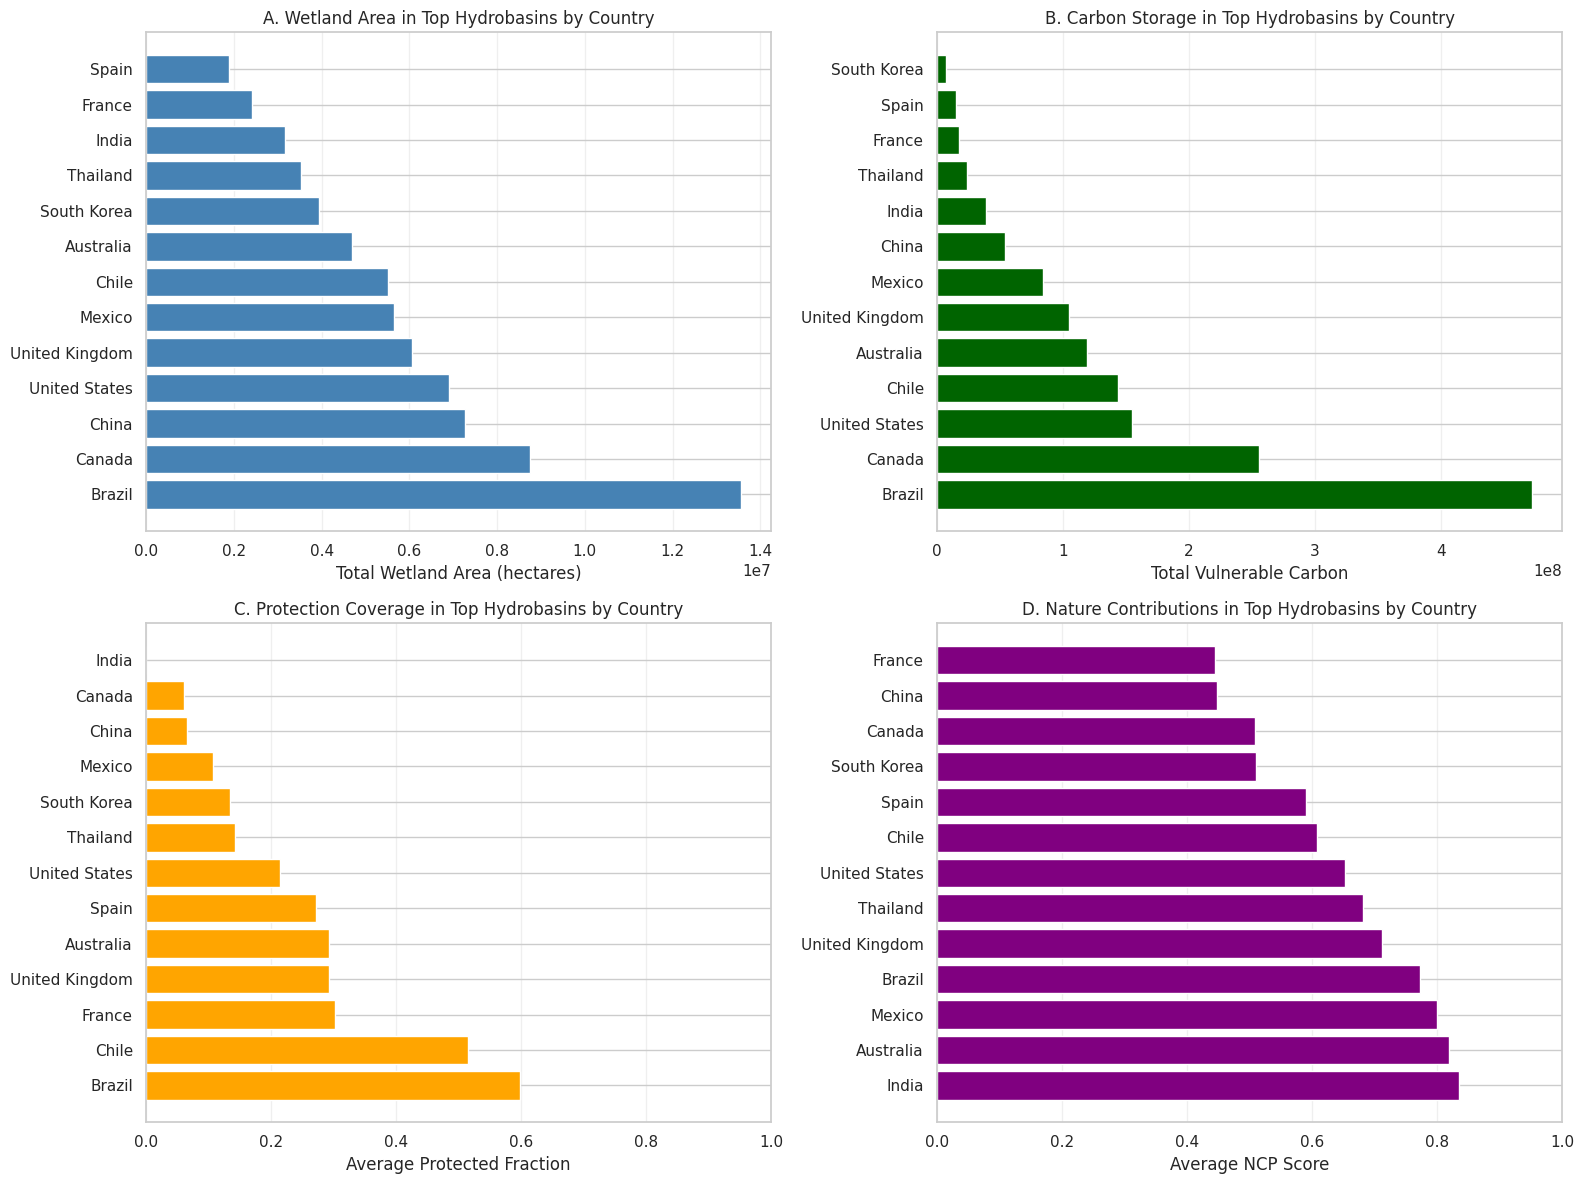

Visualization saved to: priority_hydrobasins_comparison.png


In [18]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Wetland Area by Country
country_totals = all_results.groupby('country')['wetland_area_hectares'].sum().sort_values(ascending=False)
axes[0, 0].barh(country_totals.index, country_totals.values, color='steelblue')
axes[0, 0].set_xlabel('Total Wetland Area (hectares)')
axes[0, 0].set_title('A. Wetland Area in Top Hydrobasins by Country')
axes[0, 0].grid(axis='x', alpha=0.3)

# B. Carbon Storage by Country
carbon_totals = all_results.groupby('country')['total_carbon'].sum().sort_values(ascending=False)
axes[0, 1].barh(carbon_totals.index, carbon_totals.values, color='darkgreen')
axes[0, 1].set_xlabel('Total Vulnerable Carbon')
axes[0, 1].set_title('B. Carbon Storage in Top Hydrobasins by Country')
axes[0, 1].grid(axis='x', alpha=0.3)

# C. Protected Fraction by Country
protected_avg = all_results.groupby('country')['protected_fraction'].mean().sort_values(ascending=False)
axes[1, 0].barh(protected_avg.index, protected_avg.values, color='orange')
axes[1, 0].set_xlabel('Average Protected Fraction')
axes[1, 0].set_title('C. Protection Coverage in Top Hydrobasins by Country')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].grid(axis='x', alpha=0.3)

# D. NCP Score by Country
ncp_avg = all_results.groupby('country')['avg_ncp_score'].mean().sort_values(ascending=False)
axes[1, 1].barh(ncp_avg.index, ncp_avg.values, color='purple')
axes[1, 1].set_xlabel('Average NCP Score')
axes[1, 1].set_title('D. Nature Contributions in Top Hydrobasins by Country')
axes[1, 1].set_xlim(0, 1)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('priority_hydrobasins_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: priority_hydrobasins_comparison.png")

/tmp/ipykernel_2222782/35796866.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_results, x='country', y='composite_score', palette='Set2')


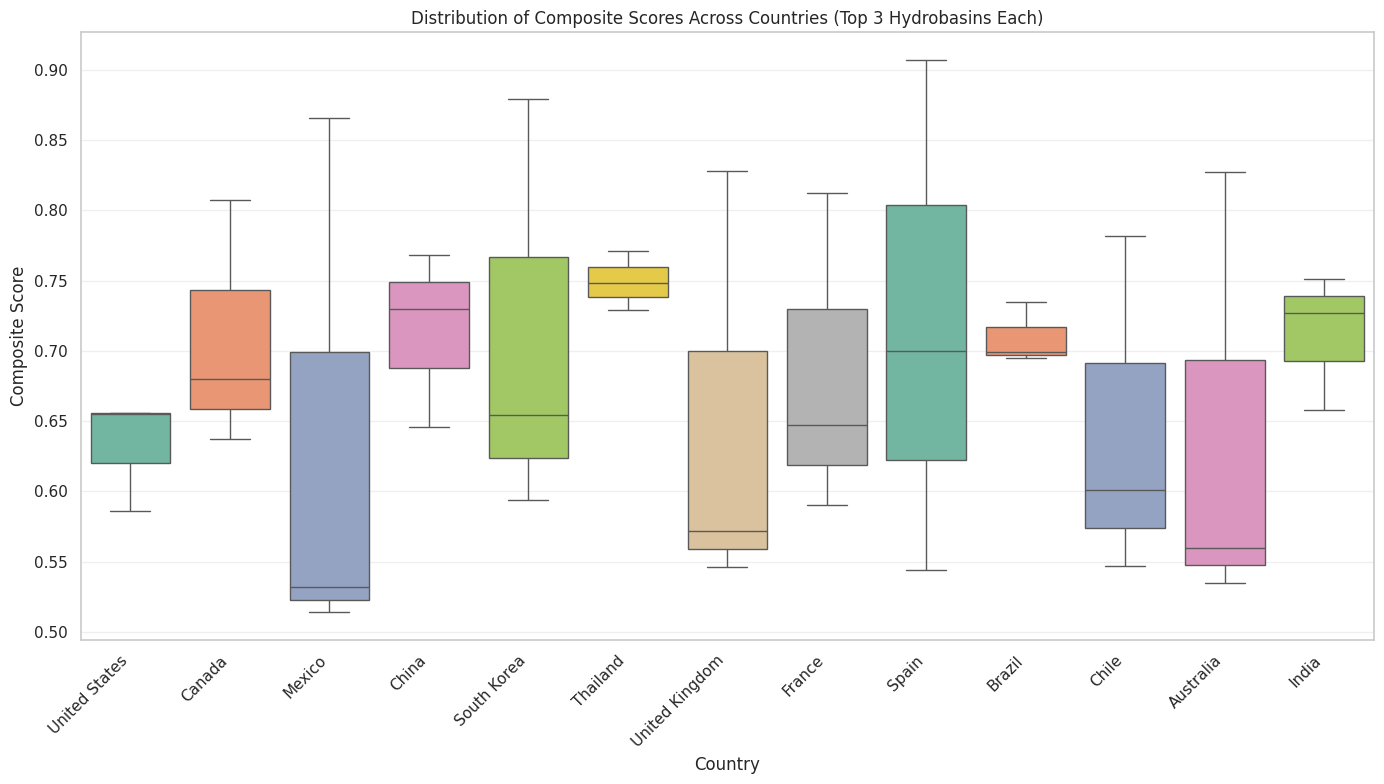

Composite score distribution saved to: composite_score_distribution.png


In [19]:
# Composite score comparison
plt.figure(figsize=(14, 8))
sns.boxplot(data=all_results, x='country', y='composite_score', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Country')
plt.ylabel('Composite Score')
plt.title('Distribution of Composite Scores Across Countries (Top 3 Hydrobasins Each)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('composite_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Composite score distribution saved to: composite_score_distribution.png")

## Key Findings

### Methodology

For each country, we identified the top 3 Level 6 HydroBASINS based on a composite score that equally weights four key metrics:

1. **Wetland Area (25%)**: Total hectares of wetlands from GLWD
2. **Carbon Storage (25%)**: Vulnerable carbon in wetlands
3. **Protection Status (25%)**: Fraction of wetlands within WDPA protected areas
4. **Nature's Contributions (25%)**: Average NCP biodiversity score

### Interpretation

The composite score helps identify hydrobasins that balance multiple conservation priorities:
- High wetland area indicates ecological significance
- High carbon storage suggests climate mitigation importance
- Low protection fraction highlights conservation gaps
- High NCP scores indicate biodiversity value and ecosystem services

### Next Steps

The results can be used to:
- Prioritize watersheds for conservation investment
- Identify protection gaps in high-value wetlands
- Support climate and biodiversity policy decisions
- Guide restoration and protection efforts